### Modeling the vibrational behavior in a isotropic model of the tympanic membrane.

The tympanic membrane is a structure that resides in our ear. The behavior of that little membrane can be modeled by the wave equation:

\begin{equation}
\frac{\partial^2 u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}
\end{equation}

This equation will be constrained by the values:

\begin{equation}
0<x<l\hspace{2mm} \land\hspace{2mm} 0<t<t_f
\end{equation}

The boundary conditions of our system will be:

\begin{equation}
u(0,t)=u(l,t)=0 \hspace{2mm}
\end{equation}

And the initial conditions are:

\begin{equation}
\frac{\partial u_x^0}{\partial t}=0 \hspace{2mm}\land\hspace{2mm} u(x,0)=sin(\pi x)+\frac{1}{2}cos(3\pi x)
\end{equation}

The values that we can use are:

* $L_T=4x10^{-5}m$ that is the large of the tense part.
* $L_f=1x10^{-4}m$ that is the large of the flacid part.
* $t_0=0$
* $t_f=2.42x10^{-7}s$
* $E=2x10^7Pa$
* $\rho_T=1000kg/m^3$ being the density of the tense part.
* $\rho_f=1200kg/m^3$ being the density of the flacid part.
* $\mu=0.3$ being the Poison module.

In this case, the propagation velocity $(c)$ is:

\begin{equation}
c=\sqrt{\frac{E}{\rho}\frac{(1-\mu)}{((1+\mu)(1-2\mu))}}
\end{equation}


I'm gonna use finite difference to solve the PDE.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import njit
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#First, i'm gonna create all the variables.

lt=4e-5
lf=1e-4
tf=2.42e-7
E=2e7
rhot=1000
rhof=1200
mu=0.3 

#Now, create the variable c
ct=np.sqrt((E/rhot)*((1-mu)/((1+mu)*(1-2*mu))))
cf=np.sqrt((E/rhof)*((1-mu)/((1+mu)*(1-2*mu))))

#Now, choose the number of grid points
Nx=551
Nt=551
dxt=(lt)/(Nx-1)
dxf=(lf)/(Nx-1)
dt=(tf)/(Nt-1)

#Create the arrays for x and t
xt=np.linspace(0,lt,Nx)
xf=np.linspace(0,lf,Nx)
t=np.linspace(0,tf,Nt)

@njit() #Create a function that calculates the cfl condition
def cfl(c,dt,dx):
    return c*(dt/dx)

#Use it to calculate the CFL condition
kt=cfl(ct,dt,dxt)
kf=cfl(cf,dt,dxf)

print('''The CFL condition is 
kt={f}
kf={d}'''.format(f=kt,d=kf))

The CFL condition is 
kf=0.9926993115122639
kl=0.3624825371567432


## Explicit Method

Now, it's time to make to use Finite Difference with our equation. The discretized derivates are:

\begin{equation}
\frac{\partial^2 u}{\partial x^2}\approx\frac{u_{x+1}^{t}-2u_{x}^{t}+u_{x-1}^{t}}{\Delta x^2}
\end{equation}

\begin{equation}
\frac{\partial^2 u}{\partial t^2}\approx\frac{u_{x}^{t+1}-2u_{x}^{t}+u_{x}^{t-1}}{\Delta t^2}
\end{equation}

The discretized equation is:

\begin{equation}
\frac{u_{x}^{t+1}-2u_{x}^{t}+u_{x}^{t-1}}{\Delta t^2}=c^2\frac{u_{x+1}^{t}-2u_{x}^{t}+u_{x-1}^{t}}{\Delta x^2}
\end{equation}

Now, we can use some algebra and get the next equation:

\begin{equation}
u_x^{t+1}=k^2(u_{x+1}^{t}+u_{x-1}^{t})+2u_{x}^{t}(1-k^2)-u_x^{t-1}
\end{equation}

where $k=c\frac{dt}{dx}$.

This equation can now be programmed. But first, we need to check the first time step so we can calculate $u_x^2$ using $u_x^1$ and $u_x^0$. That means:

\begin{equation}
u_x^1=k^2(u_{x+1}^{0}+u_{x-1}^{0})+2u_{x}^{0}(1-k^2)-u_x^{-1}
\end{equation}

We don't know $u_x^{-1}$, that's outside our time domain and our time mesh, how we can calculate? Well, we can calculate the discretized form our a first time derivate, that means:

\begin{equation}
\frac{\partial u_x^{0}}{\partial t}\approx\frac{u_x^1-u_x^{-1}}{2\Delta t}
\end{equation}

We know that from our initial conditions, we can get $\frac{\partial u_x^0}{\partial t}=0$. So we have:

\begin{equation} u_x^{-1}=u_x^1 \end{equation}

So, back to our equation to calculate $u_x^1$, we have:

\begin{equation}
u_x^1=\frac{1}{2}k^2(u_{x+1}^{0}+u_{x-1}^{0})+u_{x}^{0}(1-k^2)
\end{equation}

Now, we have everything that we need for compute the solution.

Thanks to the book **Finite Difference Computing with PDEs** written by Hans Petter Langtangen and Svein Linge.

In [3]:
@njit() #Function to execute finite difference method
def fdm(Nx,Nt,l,tf,k,x,t,n):
    u=np.zeros((Nx,Nt))
    u=BC(u,l,Nx,Nt) #First, we initialize the BC
    u=IC(u,Nt,Nx,x,k,n,l) #And nowm we calculate the IC

    for j in range(1,Nt-1):
        for i in range(Nx-1):
            u[i,j+1]=k**2*(u[i+1,j]+u[i-1,j])+2*u[i,j]*(1-k**2)-u[i,j-1]
        u=BC(u,l,Nx,Nt)
    return u

@njit() #With this, we can calculate the initial conditions
def IC(u,Nt,Nx,x,k,n,l):
    for j in range(1,Nx-2):
        u[j,0]=np.sin(n*np.pi*x[j]/l)
        #u[j,0]=np.sin(np.pi*x[i])+0.5*np.sin(3*np.pi*x[i])
    for i in range(Nx-1):
        u[i,1]=0.5*k**2*(u[i+1,0]+u[i-1,0])+u[i,0]*(1-k**2)
    return u

@njit() #This is for the boundary conditions
def BC(u,l,Nx,Nt):
    for j in range(Nt-1):
        u[0,j]=0
        u[Nx-1,j]=0
    return u

Now, we can calculate the results and plotting them

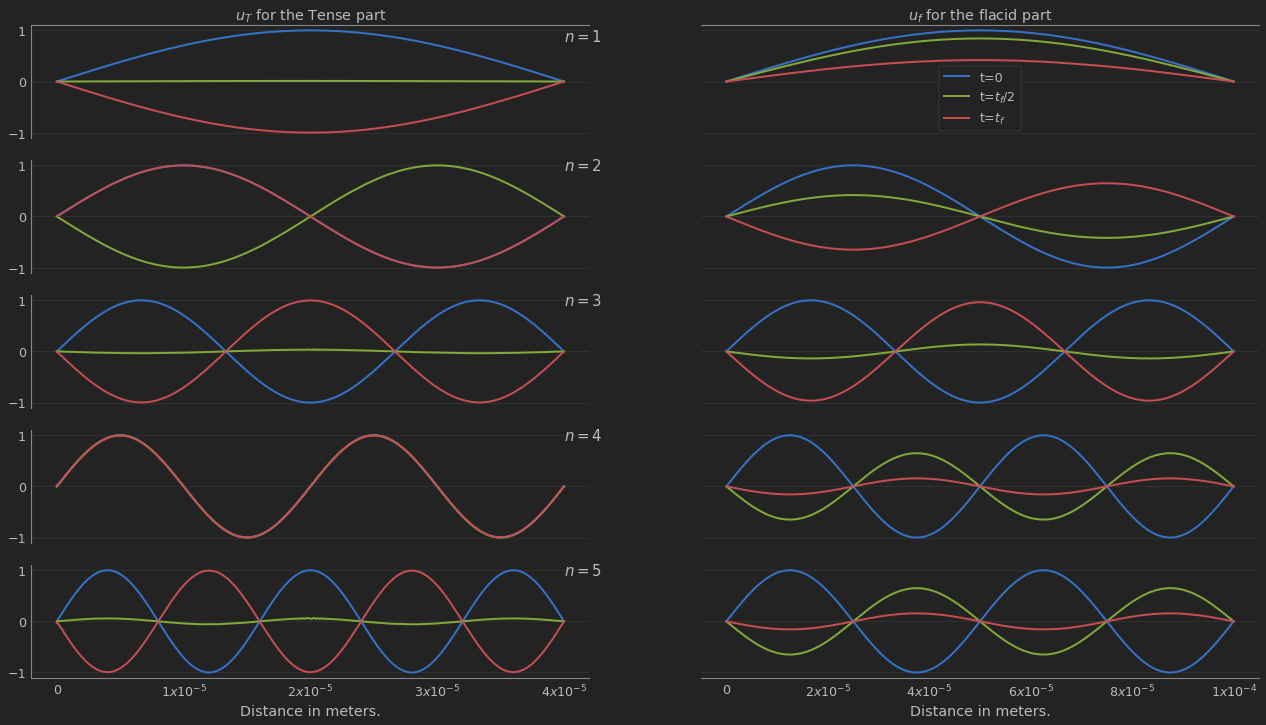

In [9]:
#Chose the vibrational node

#n=1
ut1=fdm(Nx,Nt,lt,tf,kt,xt,t,1)
uf1=fdm(Nx,Nt,lf,tf,kf,xf,t,1)
#n=2
ut2=fdm(Nx,Nt,lt,tf,kt,xt,t,2)
uf2=fdm(Nx,Nt,lf,tf,kf,xf,t,2)
#n=3
ut3=fdm(Nx,Nt,lt,tf,kt,xt,t,3)
uf3=fdm(Nx,Nt,lf,tf,kf,xf,t,3)
#n=4
ut4=fdm(Nx,Nt,lt,tf,kt,xt,t,4)
uf4=fdm(Nx,Nt,lf,tf,kf,xf,t,4)
#n=5
ut5=fdm(Nx,Nt,lt,tf,kt,xt,t,5)
uf5=fdm(Nx,Nt,lf,tf,kf,xf,t,5)

@njit()
def real(Nx,Nt,c,t,x,l):
    ureal=np.zeros((Nx,Nt))
    for j in range(Nt-1):
        for i in range(Nx-1):
            ureal[i,j]=np.cos(n*np.pi*c*t[j]/l)*np.sin(n*np.pi*x[i]/l)
    return ureal

#%time ureal=real(Nx,Nt,ct,t,xt,lt)

#Plot the results
fig, axs=plt.subplots(5,2,figsize=(22,12),sharex=False, sharey=True)

#Plots for ut
axs[0,0].set_title('$u_T$ for the Tense part')
#Plot for n=1
axs[0,0].plot(xt,ut1[:,0],lw=2, label='t=0')
axs[0,0].plot(xt,ut1[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[0,0].plot(xt,ut1[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].text(4e-5,0.8,'$n=1$',fontsize=15)
axs[0,0].set_xticks([])

#Plot for n=2
axs[1,0].plot(xt,ut2[:,0],lw=2, label='t=0')
axs[1,0].plot(xt,ut2[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[1,0].plot(xt,ut2[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].text(4e-5,0.9,'$n=2$',fontsize=15)
axs[1,0].set_xticks([])

#Plot for n=3
axs[2,0].plot(xt,ut3[:,0],lw=2, label='t=0')
axs[2,0].plot(xt,ut3[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[2,0].plot(xt,ut3[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)
axs[2,0].spines['bottom'].set_visible(False)
axs[2,0].text(4e-5,0.9,'$n=3$',fontsize=15)
axs[2,0].set_xticks([])

#Plot for n=4
axs[3,0].plot(xt,ut4[:,0],lw=2, label='t=0')
axs[3,0].plot(xt,ut4[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[3,0].plot(xt,ut4[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[3,0].spines['top'].set_visible(False)
axs[3,0].spines['right'].set_visible(False)
axs[3,0].spines['bottom'].set_visible(False)
axs[3,0].text(4e-5,0.9,'$n=4$',fontsize=15)
axs[3,0].set_xticks([])

#Plot for n=5
axs[4,0].plot(xt,ut5[:,0],lw=2, label='t=0')
axs[4,0].plot(xt,ut5[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[4,0].plot(xt,ut5[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[4,0].spines['top'].set_visible(False)
axs[4,0].spines['right'].set_visible(False)
axs[4,0].text(4e-5,0.9,'$n=5$',fontsize=15)
axs[4,0].set_xticks([0,1e-5,2e-5,3e-5,4e-5])
axs[4,0].set_xticklabels(['0','$1x10^{-5}$','$2x10^{-5}$','$3x10^{-5}$','$4x10^{-5}$'])
axs[4,0].set_xlabel('Distance in meters.')
axs[4,0].grid(axis='x')

#Plots for uf
axs[0,1].set_title('$u_f$ for the flacid part')
#Plot for n=1
axs[0,1].plot(xf,uf1[:,0],lw=2, label='t=0')
axs[0,1].plot(xf,uf1[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[0,1].plot(xf,uf1[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[0,1].spines['left'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['bottom'].set_visible(False)
axs[0,1].set_xticks([])

#Plot for n=2
axs[1,1].plot(xf,uf2[:,0],lw=2, label='t=0')
axs[1,1].plot(xf,uf2[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[1,1].plot(xf,uf2[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['bottom'].set_visible(False)
axs[1,1].set_xticks([])

#Plot for n=3
axs[2,1].plot(xf,uf3[:,0],lw=2, label='t=0')
axs[2,1].plot(xf,uf3[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[2,1].plot(xf,uf3[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['left'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)
axs[2,1].spines['bottom'].set_visible(False)
axs[2,1].set_xticks([])

#Plot for n=4
axs[3,1].plot(xf,uf4[:,0],lw=2, label='t=0')
axs[3,1].plot(xf,uf4[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[3,1].plot(xf,uf4[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[3,1].spines['top'].set_visible(False)
axs[3,1].spines['left'].set_visible(False)
axs[3,1].spines['right'].set_visible(False)
axs[3,1].spines['bottom'].set_visible(False)
axs[3,1].set_xticks([])

#Plot for n=5
axs[4,1].plot(xf,uf4[:,0],lw=2, label='t=0')
axs[4,1].plot(xf,uf4[:,int((Nt-1)/2)],lw=2, label='t=$t_f/2$')
axs[4,1].plot(xf,uf4[:,int(Nt-1)],lw=2, label='t=$t_f$')
axs[4,1].spines['top'].set_visible(False)
axs[4,1].spines['left'].set_visible(False)
axs[4,1].spines['right'].set_visible(False)
axs[4,1].set_xticks([0,2e-5,4e-5,6e-5,8e-5,1e-4])
axs[4,1].set_xticklabels(['0','$2x10^{-5}$','$4x10^{-5}$','$6x10^{-5}$','$8x10^{-5}$','$1x10^{-4}$'])
axs[4,1].set_xlabel('Distance in meters.')
axs[4,1].grid(axis='x')


axs[0,1].legend()

In [10]:
from matplotlib import animation,rc
rc('animation',html='html5')

fig,axs=plt.subplots(5,2,figsize=(22,12),sharex=False, sharey=True)

#for uT
#n=1
line11,=axs[0,0].plot([],[],lw=2,color='red')
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].text(4e-5,0.8,'$n=1$',fontsize=15)
axs[0,0].set_xticks([])
axs[0,0].set_xlim(0,4e-5)
axs[0,0].set_ylim(-1,1)

#n=2
line12,=axs[1,0].plot([],[],lw=2,color='teal')
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].text(4e-5,0.9,'$n=2$',fontsize=15)
axs[1,0].set_xticks([])
axs[1,0].set_xlim(0,4e-5)
axs[1,0].set_ylim(-1,1)

#n=3
line13,=axs[2,0].plot([],[],lw=2,color='green')
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)
axs[2,0].spines['bottom'].set_visible(False)
axs[2,0].text(4e-5,0.9,'$n=3$',fontsize=15)
axs[2,0].set_xticks([])
axs[2,0].set_xlim(0,4e-5)
axs[2,0].set_ylim(-1,1)

#n=4
line14,=axs[3,0].plot([],[],lw=2,color='purple')
axs[3,0].spines['top'].set_visible(False)
axs[3,0].spines['right'].set_visible(False)
axs[3,0].spines['bottom'].set_visible(False)
axs[3,0].text(4e-5,0.9,'$n=4$',fontsize=15)
axs[3,0].set_xticks([])
axs[3,0].set_xlim(0,4e-5)
axs[3,0].set_ylim(-1,1)

#n=5
line15,=axs[4,0].plot([],[],lw=2,color='orange')
axs[4,0].spines['top'].set_visible(False)
axs[4,0].spines['right'].set_visible(False)
axs[4,0].text(4e-5,0.9,'$n=5$',fontsize=15)
axs[4,0].set_xticks([0,1e-5,2e-5,3e-5,4e-5])
axs[4,0].set_xticklabels(['0','$1x10^{-5}$','$2x10^{-5}$','$3x10^{-5}$','$4x10^{-5}$'])
axs[4,0].set_xlabel('Distance in meters.')
axs[4,0].grid(axis='x')
axs[4,0].set_xlim(0,4e-5)
axs[4,0].set_ylim(-1,1)


#for uf
#n=1
line21,=axs[0,1].plot([],[],lw=2,color='red')
axs[0,1].spines['left'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['bottom'].set_visible(False)
axs[0,1].set_xticks([])
axs[0,1].set_xlim(0,1e-4)
axs[0,1].set_ylim(-1,1)

#n=2
line22,=axs[1,1].plot([],[],lw=2,color='teal')
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['bottom'].set_visible(False)
axs[1,1].set_xticks([])
axs[1,1].set_xlim(0,1e-4)
axs[1,1].set_ylim(-1,1)

#n=3
line23,=axs[2,1].plot([],[],lw=2,color='green')
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['left'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)
axs[2,1].spines['bottom'].set_visible(False)
axs[2,1].set_xticks([])
axs[2,1].set_xlim(0,1e-4)
axs[2,1].set_ylim(-1,1)

#n=4
line24,=axs[3,1].plot([],[],lw=2,color='purple')
axs[3,1].spines['top'].set_visible(False)
axs[3,1].spines['left'].set_visible(False)
axs[3,1].spines['right'].set_visible(False)
axs[3,1].spines['bottom'].set_visible(False)
axs[3,1].set_xticks([])
axs[3,1].set_xlim(0,1e-4)
axs[3,1].set_ylim(-1,1)

#n=5
line25,=axs[4,1].plot([],[],lw=2,color='orange')
axs[4,1].spines['top'].set_visible(False)
axs[4,1].spines['right'].set_visible(False)
axs[4,1].spines['left'].set_visible(False)
axs[4,1].set_xticks([0,2e-5,4e-5,6e-5,8e-5,1e-4])
axs[4,1].set_xticklabels(['0','$2x10^{-5}$','$4x10^{-5}$','$6x10^{-5}$','$8x10^{-5}$','$1x10^{-4}$'])
axs[4,1].set_xlabel('Distance in meters.')
axs[4,1].set_xlim(0,1e-4)
axs[4,1].set_ylim(-1,1)
axs[4,1].grid(axis='x')


def init():
    line11,=axs[0,0].plot([],[],lw=2,color='red')
    line12,=axs[1,0].plot([],[],lw=2,color='teal')
    line13,=axs[2,0].plot([],[],lw=2,color='green')
    line14,=axs[3,0].plot([],[],lw=2,color='purple')
    line15,=axs[4,0].plot([],[],lw=2,color='orange')
    line21,=axs[0,1].plot([],[],lw=2,color='red')
    line22,=axs[1,1].plot([],[],lw=2,color='teal')
    line23,=axs[2,1].plot([],[],lw=2,color='green')
    line24,=axs[3,1].plot([],[],lw=2,color='purple')
    line25,=axs[4,1].plot([],[],lw=2,color='orange')
    
    return line11,line12,line13,line14,line15,line21,line22,line23,line24,line25 

def animate(i):
    global xt, xf, t, ut1, uf1, ut2, uf2, ut3, uf3, ut4, uf4, ut5, uf5
    #For ut
    line11.set_data(xt,ut1[:,i])
    line12.set_data(xt,ut2[:,i])
    line13.set_data(xt,ut3[:,i])
    line14.set_data(xt,ut4[:,i])
    line15.set_data(xt,ut5[:,i])
    axs[0,0].set_title('$u_T$ for the tense part at t={0:.2f} nanoseconds'.format(t[i]*1e9))
    #For uf
    line21.set_data(xf,uf1[:,i])
    line22.set_data(xf,uf2[:,i])
    line23.set_data(xf,uf3[:,i])
    line24.set_data(xf,uf4[:,i])
    line25.set_data(xf,uf5[:,i])
    axs[0,1].set_title('$u_f$ for the flacid part at t={0:.2f} nanoseconds'.format(t[i]*1e9))
    
    return line11,line12,line13,line14,line15,line21,line22,line23,line24,line25 

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=Nt,interval=200,blit=True)

plt.close()
%time anim.save('Membrane.mp4',fps=60,extra_args=['-vcodec','libx264'])

CPU times: user 3min 57s, sys: 6.73 s, total: 4min 4s
Wall time: 4min 12s
